<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?
<Ответ>

В пространстве ответов алгоритмов. Его размерность -- количество сэмплов в обучающей выборке.

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?
<Ответ>

Потому что глубокие деревья сильно переобучаются, это к тому же сильно увеличивает время работы алгоритма.

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками а что целевой переменной?)

<Ответ>
Оно предсказывает градиент функции потерь по ответам предыдущего алгоритма.
Признаки это тот же набор признаков тренировочной выборки X.

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [1]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


/Users/fogside/virtualenvs/python2_env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from copy import deepcopy
from scipy.optimize import minimize_scalar
from scipy.special import expit


class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_estimator, n_estimators, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
    
    def loss_grad(self, original_y, pred_y):
        
        loss_gr = original_y*expit(-original_y*pred_y)
        
        return loss_gr # Градиент на каждом объекте
    
    def _mse(self, gamma, y, y_pred, y_prev_pred):
        return np.sum((y_prev_pred  + gamma * y_pred - y) ** 2)
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = []
        self.gammas_ = []
        
        g = 1
        for i in range(self.n_estimators):
            y_prev_pred = self._predict(X)
            grad = self.loss_grad(original_y, y_prev_pred)
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?

            estimator = deepcopy(self.base_estimator)
            estimator.fit(X, grad)
            self.estimators_.append(estimator)
            g = self.lr * minimize_scalar(lambda(x):self._mse(x, original_y, estimator.predict(X), y_prev_pred)).x
            self.gammas_.append(g)

        return self

    def _predict(self, X):
        
        X = np.array(X)
        if self.estimators_ == []:
            return [0]*len(X)
        else:
            y_pred = np.sum([b.predict(X)*g for b,g in zip(self.estimators_, self.gammas_)], axis = 0)
            
        return y_pred
    
    def predict(self, X):
        y_pred = sign(self._predict(X))
        return y_pred


<h1 align="center">Simple test</h1> 

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

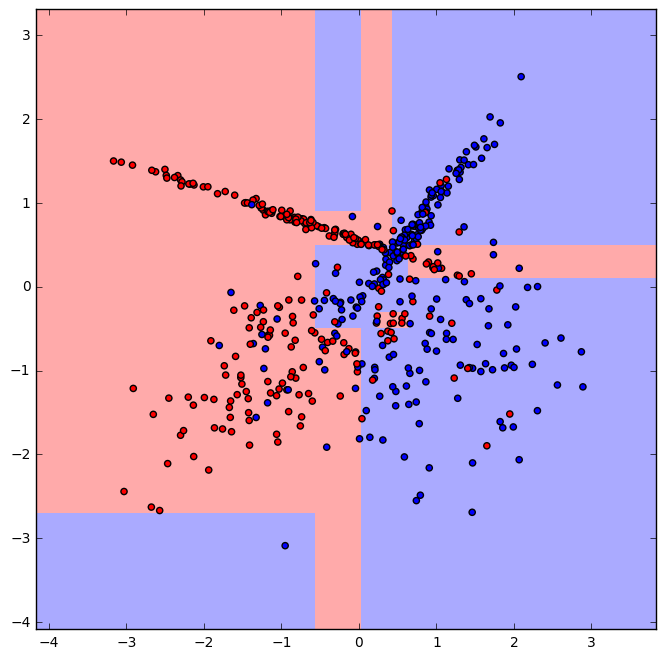

In [4]:
tree = DecisionTreeRegressor(criterion='friedman_mse',splitter='best', max_depth=4)
clf = BinaryBoostingClassifier(tree, n_estimators=100).fit(X, y)
plot_surface(X, y, clf)

<h1 align="center">Adult test</h1> 

#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [27]:
!pwd

/Users/fogside/Projects/DataScience/MIPT_Data_Mining_In_Action_2016/base/hw01v2


In [5]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [6]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [11]:
# <Сверьте качество своего алгоритма с GradientBoostingClassifier, оно должно быть примерно таким-же>
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

gbc = GradientBoostingClassifier()

tree = DecisionTreeRegressor(criterion='friedman_mse',splitter='best', max_depth=3)
clf = BinaryBoostingClassifier(tree, n_estimators=100)

In [12]:
cross_val_score(clf,X,y)

array([ 0.83886125,  0.84429703,  0.84787616])

In [13]:
cross_val_score(gbc,X,y)

array([ 0.86217063,  0.86493459,  0.86998986])

<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [44]:
clf.loss_grad (np.array([-1, 1, 1]), np.array([-1, 1, -1])).sum()

0.7310585786300049